# Exploratory Data Analysis (EDA)

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")
sns.set_style("white")
plt.rcParams['figure.figsize'] = (12, 6)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


## 1. Dataset Overview


In [25]:
# Load the feature-engineered dataset
df = pd.read_csv('../data/knight_hacks_dues_processed.csv')

print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"Shape: {df.shape}")
print(f"Rows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\n" + "="*80)


DATASET OVERVIEW
Shape: (838, 36)
Rows: 838
Columns: 36

Memory usage: 0.37 MB



In [26]:
# Basic info
print("DATASET INFO")
print("="*80)
df.info()


DATASET INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   member_days_since_join        838 non-null    int64  
 1   events_attended_year          838 non-null    int64  
 2   distinct_event_days_year      838 non-null    int64  
 3   attendance_streak_weeks       838 non-null    int64  
 4   n_gbm_year                    838 non-null    int64  
 5   n_social_year                 838 non-null    int64  
 6   n_hello_world_year            838 non-null    int64  
 7   n_sponsorship_year            838 non-null    int64  
 8   n_tech_exploration_year       838 non-null    int64  
 9   n_class_support_year          838 non-null    int64  
 10  class_support_ratio           838 non-null    float64
 11  n_workshop_year               838 non-null    int64  
 12  n_ops_year                    838 non-null    int64

In [27]:
# Missing values check
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing Count': missing.values,
    'Missing Percentage': missing_pct.values
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    print("MISSING VALUES")
    print("="*80)
    print(missing_df.to_string(index=False))
else:
    print("No missing values in the dataset!")


No missing values in the dataset!


## 2. Target Variable Analysis


TARGET VARIABLE DISTRIBUTION
Class 0 (Did not pay dues): 564 (67.30%)
Class 1 (Paid dues): 274 (32.70%)

Imbalance Ratio: 2.06:1


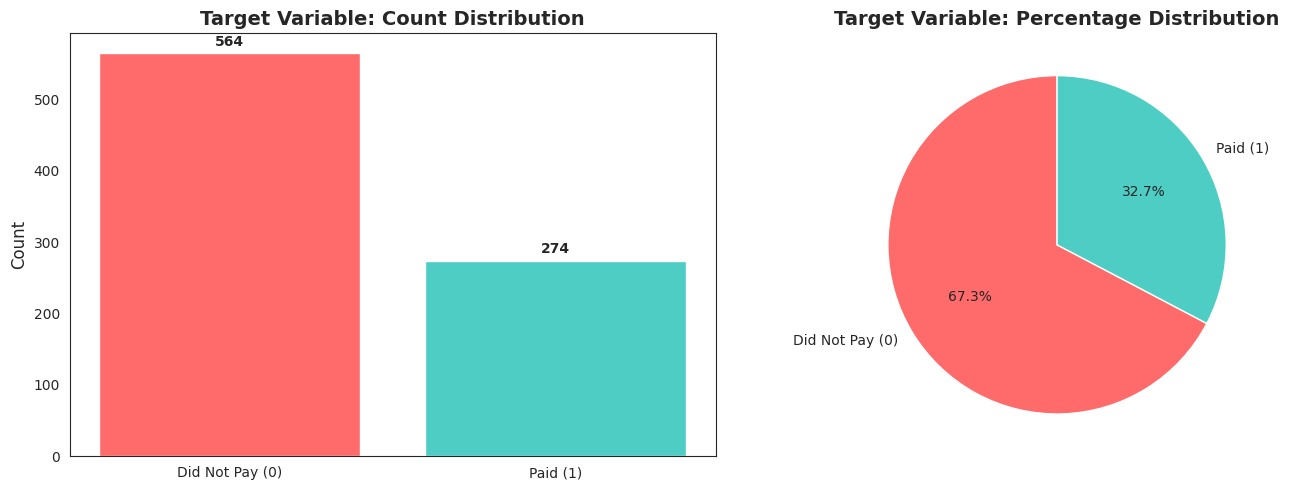

In [28]:
# Target variable distribution
target_col = 'y_paid_dues'
target_counts = df[target_col].value_counts()
target_pct = df[target_col].value_counts(normalize=True) * 100

print("TARGET VARIABLE DISTRIBUTION")
print("="*80)
print(f"Class 0 (Did not pay dues): {target_counts[0]:,} ({target_pct[0]:.2f}%)")
print(f"Class 1 (Paid dues): {target_counts[1]:,} ({target_pct[1]:.2f}%)")
print(f"\nImbalance Ratio: {target_counts[0] / target_counts[1]:.2f}:1")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
axes[0].bar(['Did Not Pay (0)', 'Paid (1)'], target_counts.values, color=['#FF6B6B', '#4ECDC4'])
axes[0].set_title('Target Variable: Count Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].grid(False)
for i, v in enumerate(target_counts.values):
    axes[0].text(i, v + 10, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(target_counts.values, labels=['Did Not Pay (0)', 'Paid (1)'], 
            autopct='%1.1f%%', colors=['#FF6B6B', '#4ECDC4'], startangle=90)
axes[1].set_title('Target Variable: Percentage Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)


## 3. Correlation Analysis


In [29]:
# Separate numerical features
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numerical_cols:
    numerical_cols.remove(target_col)

# Compute correlation matrix
corr_matrix = df[numerical_cols + [target_col]].corr()

# Correlation with target variable
target_corr = corr_matrix[target_col].drop(target_col).sort_values(ascending=False)

print("TOP 15 FEATURES CORRELATED WITH TARGET")
print("="*80)
print("\nPositive Correlations:")
print(target_corr[target_corr > 0].head(15).to_string())
print("\nNegative Correlations:")
print(target_corr[target_corr < 0].tail(10).to_string())


TOP 15 FEATURES CORRELATED WITH TARGET

Positive Correlations:
attendance_streak_weeks         0.338341
has_gone_to_hackathon           0.332712
distinct_event_days_year        0.321842
engagement_breadth              0.280154
has_role_ops                    0.276730
discord_num_roles               0.272789
n_ops_year                      0.267069
events_attended_year            0.264785
social_score                    0.262453
n_gbm_year                      0.257221
discord_channels_posted_year    0.246623
ops_ratio                       0.218418
n_collabs_year                  0.217229
n_hello_world_year              0.206544
left_any_feedback               0.195973

Negative Correlations:
avg_event_rating_given    -0.010911
is_sponsor_hunter         -0.038359
n_class_support_year      -0.069275
discord_days_since_join   -0.071264
class_support_ratio       -0.167111
member_days_since_join    -0.241104


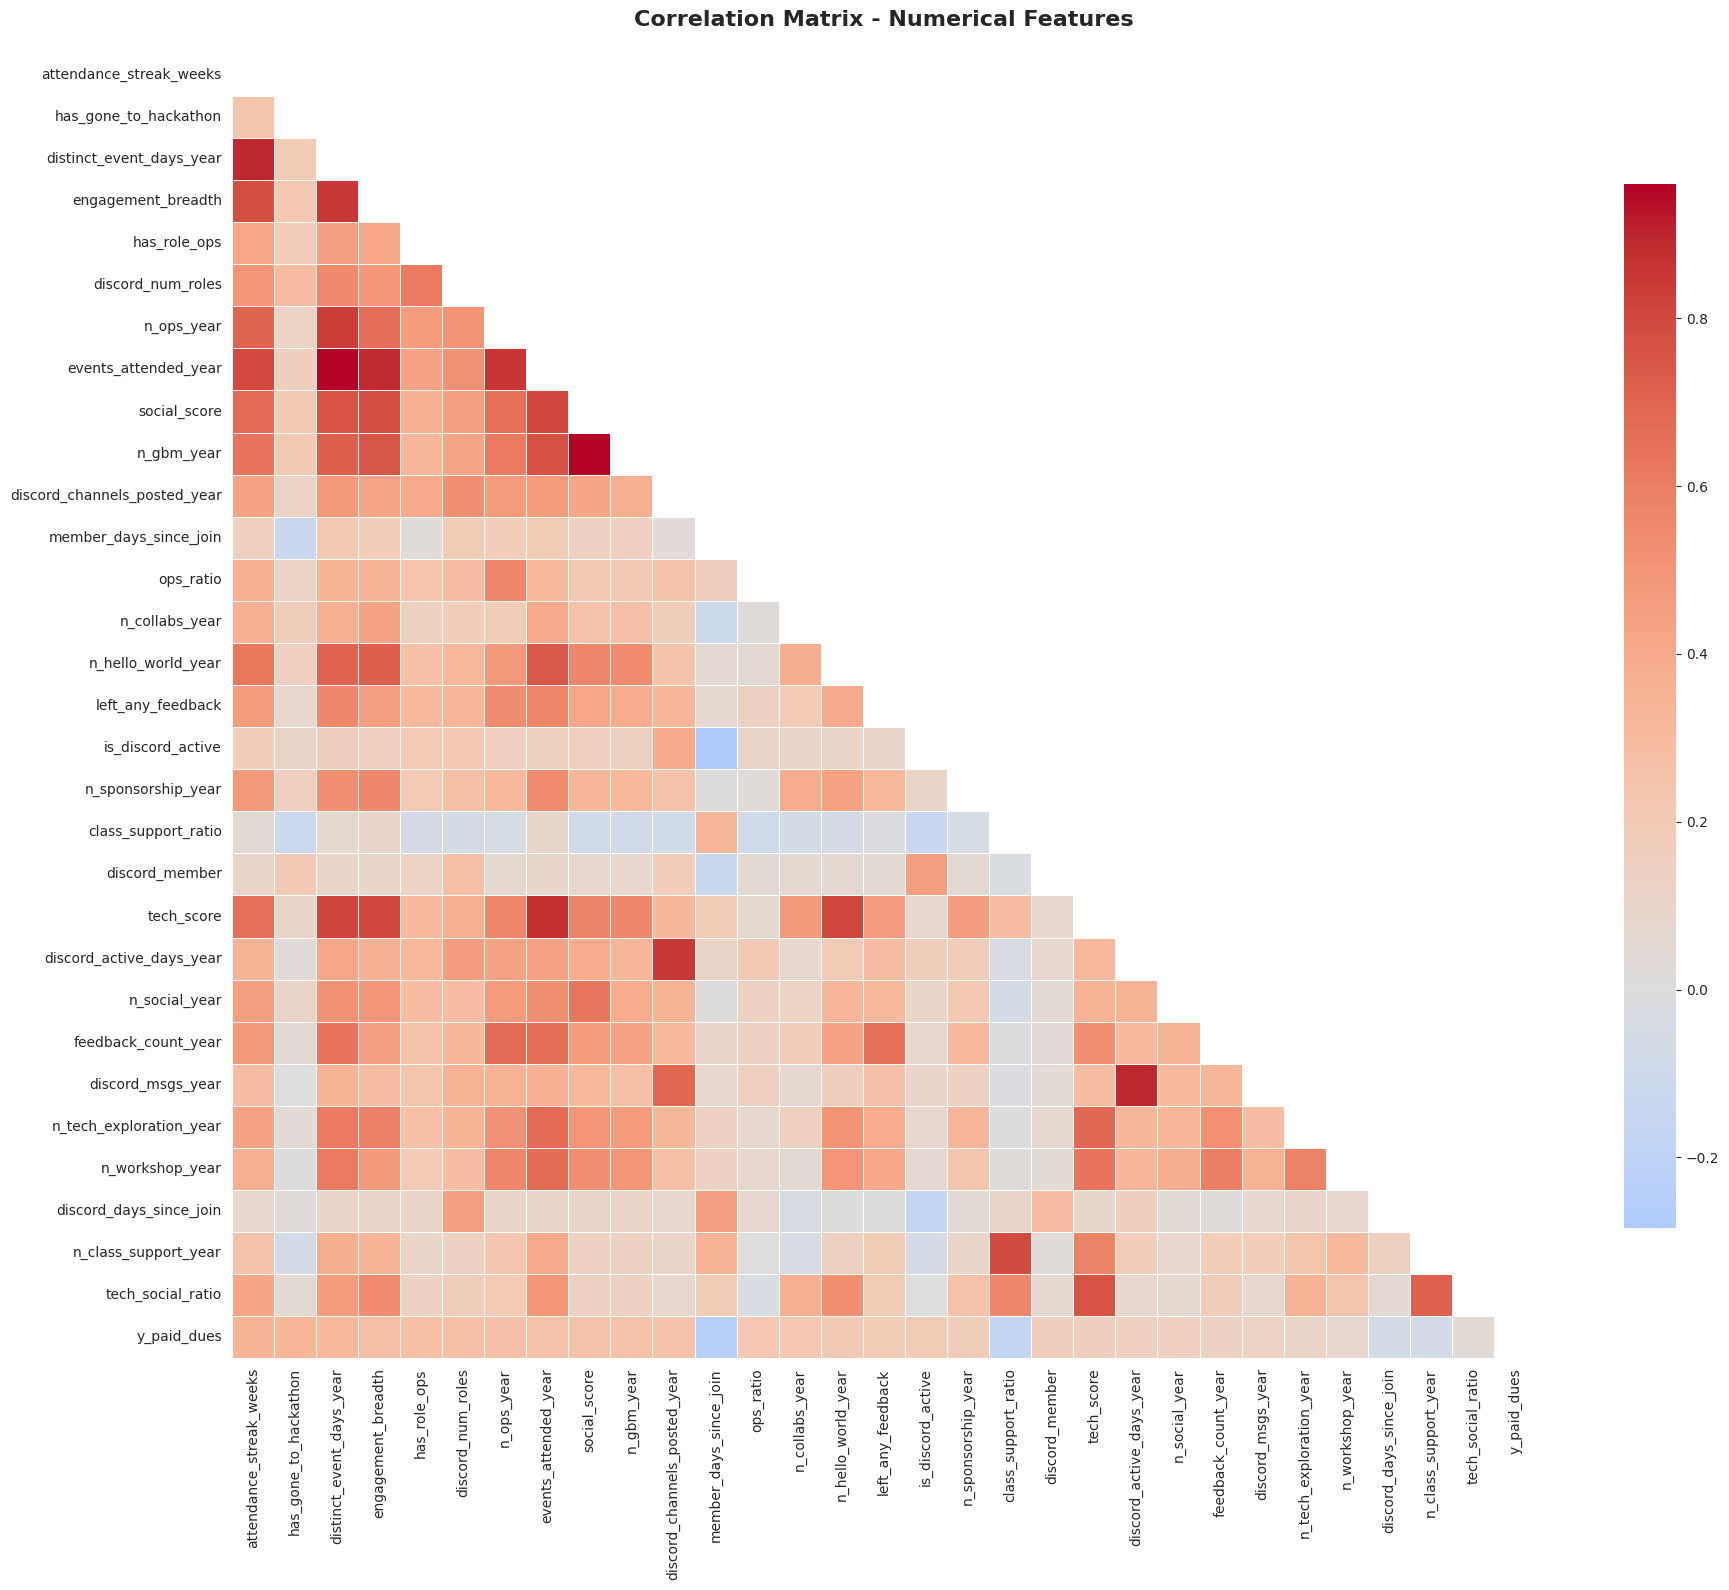

In [30]:
# Correlation heatmap - Full matrix
plt.figure(figsize=(20, 16))

# Use a subset if too many features
if len(numerical_cols) > 30:
    # Select top correlated features + target
    top_features = abs(target_corr).nlargest(30).index.tolist()
    corr_subset = df[top_features + [target_col]].corr()
    mask = np.triu(np.ones_like(corr_subset, dtype=bool))
    sns.heatmap(corr_subset, annot=False, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, mask=mask)
else:
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, annot=False, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, mask=mask)

plt.title('Correlation Matrix - Numerical Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


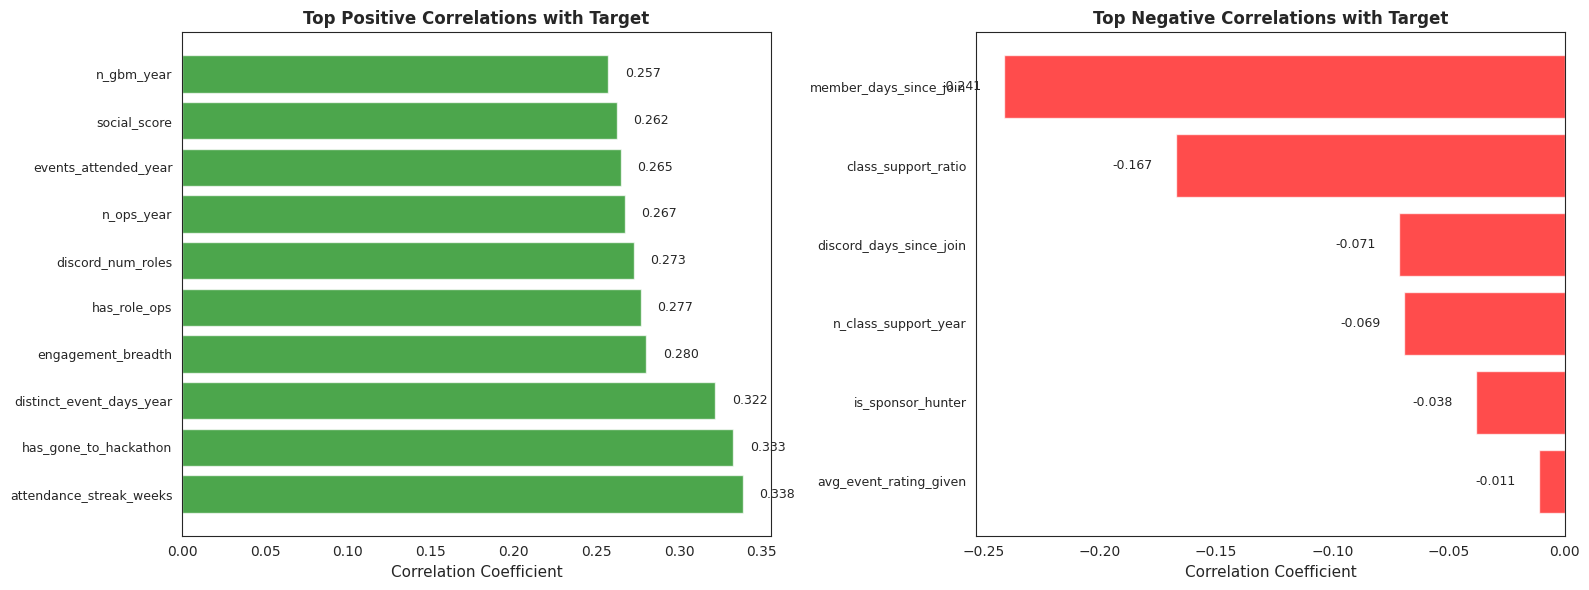

In [31]:
# Bar plot of correlations with target
top_pos = target_corr[target_corr > 0].head(10)
top_neg = target_corr[target_corr < 0].tail(10)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Positive correlations
axes[0].barh(range(len(top_pos)), top_pos.values, color='green', alpha=0.7)
axes[0].set_yticks(range(len(top_pos)))
axes[0].set_yticklabels(top_pos.index, fontsize=9)
axes[0].set_xlabel('Correlation Coefficient', fontsize=11)
axes[0].set_title('Top Positive Correlations with Target', fontsize=12, fontweight='bold')
axes[0].grid(False)
for i, v in enumerate(top_pos.values):
    axes[0].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

# Negative correlations
axes[1].barh(range(len(top_neg)), top_neg.values, color='red', alpha=0.7)
axes[1].set_yticks(range(len(top_neg)))
axes[1].set_yticklabels(top_neg.index, fontsize=9)
axes[1].set_xlabel('Correlation Coefficient', fontsize=11)
axes[1].set_title('Top Negative Correlations with Target', fontsize=12, fontweight='bold')
axes[1].grid(False)
for i, v in enumerate(top_neg.values):
    axes[1].text(v - 0.01, i, f'{v:.3f}', va='center', fontsize=9, ha='right')

plt.tight_layout()
plt.show()


## 4. Numerical Features Analysis


In [32]:
# Summary statistics for numerical features
print("SUMMARY STATISTICS - NUMERICAL FEATURES")
print("="*80)
df[numerical_cols].describe().T


SUMMARY STATISTICS - NUMERICAL FEATURES


,count,mean,std,min,25%,50%,75%,max
member_days_since_join,838.0,186.352029,114.505895,12.000000,70.000000,251.500000,298.000000,309.0
events_attended_year,838.0,1.856802,3.578246,0.000000,0.000000,1.000000,2.000000,34.0
distinct_event_days_year,838.0,2.538186,4.488440,0.000000,0.000000,1.000000,3.000000,39.0
attendance_streak_weeks,838.0,1.251790,1.677696,0.000000,0.000000,1.000000,1.000000,10.0
n_gbm_year,838.0,0.353222,0.714625,0.000000,0.000000,0.000000,1.000000,5.0
n_social_year,838.0,0.060859,0.258421,0.000000,0.000000,0.000000,0.000000,2.0
n_hello_world_year,838.0,0.298329,0.717937,0.000000,0.000000,0.000000,0.000000,5.0
n_sponsorship_year,838.0,0.163484,0.448817,0.000000,0.000000,0.000000,0.000000,4.0
n_tech_exploration_year,838.0,0.095465,0.403632,0.000000,0.000000,0.000000,0.000000,4.0
n_class_support_year,838.0,0.232697,0.689245,0.000000,0.000000,0.000000,0.000000,4.0


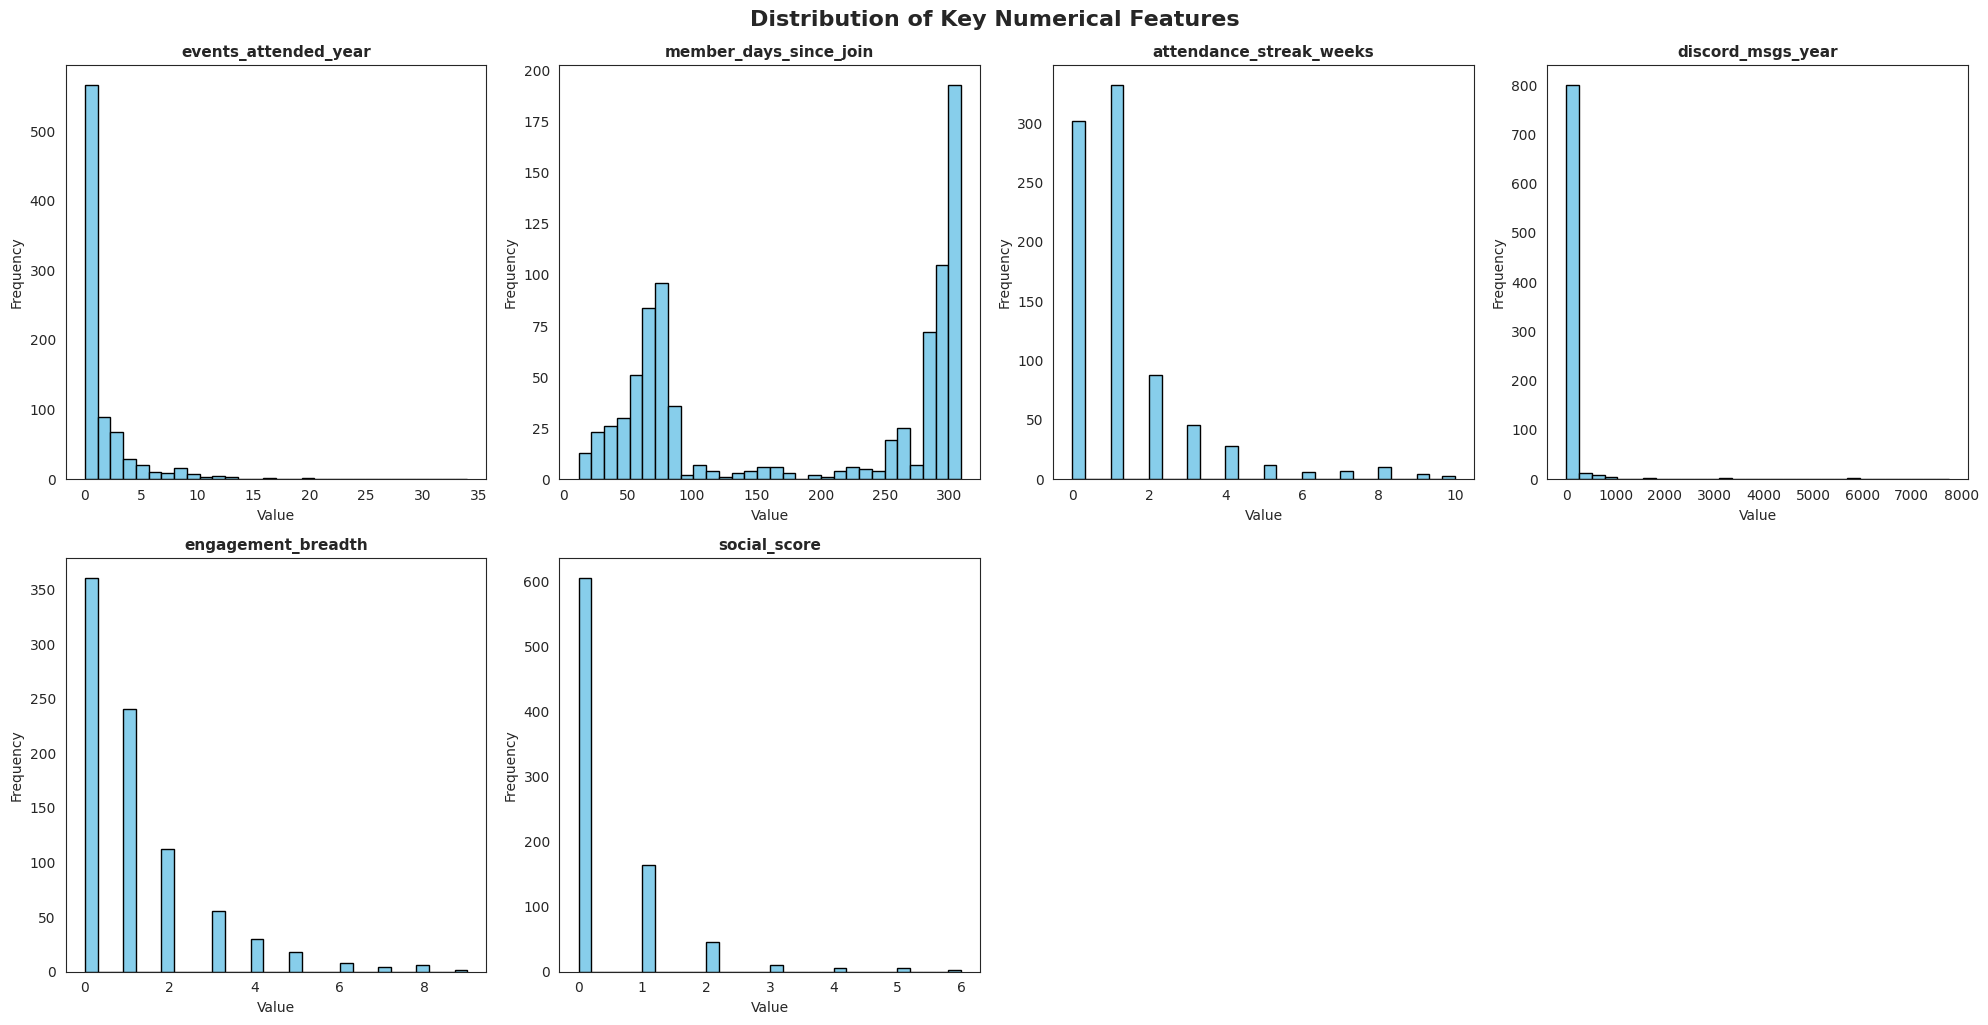

In [39]:
# Distribution of key numerical features
key_features = ['events_attended_year', 'member_days_since_join', 'attendance_streak_weeks',
                'discord_msgs_year', 'engagement_breadth', 'distinct_events_attended_year', 'social_score']

# Filter to features that exist
key_features = [f for f in key_features if f in numerical_cols]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, feature in enumerate(key_features[:8]):
    if idx < len(axes):
        df[feature].hist(bins=30, ax=axes[idx], color='skyblue', edgecolor='black')
        axes[idx].set_title(f'{feature}', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('Value')
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(False)

# Hide extra subplots
for idx in range(len(key_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.suptitle('Distribution of Key Numerical Features', fontsize=16, fontweight='bold', y=1.02)
plt.show()


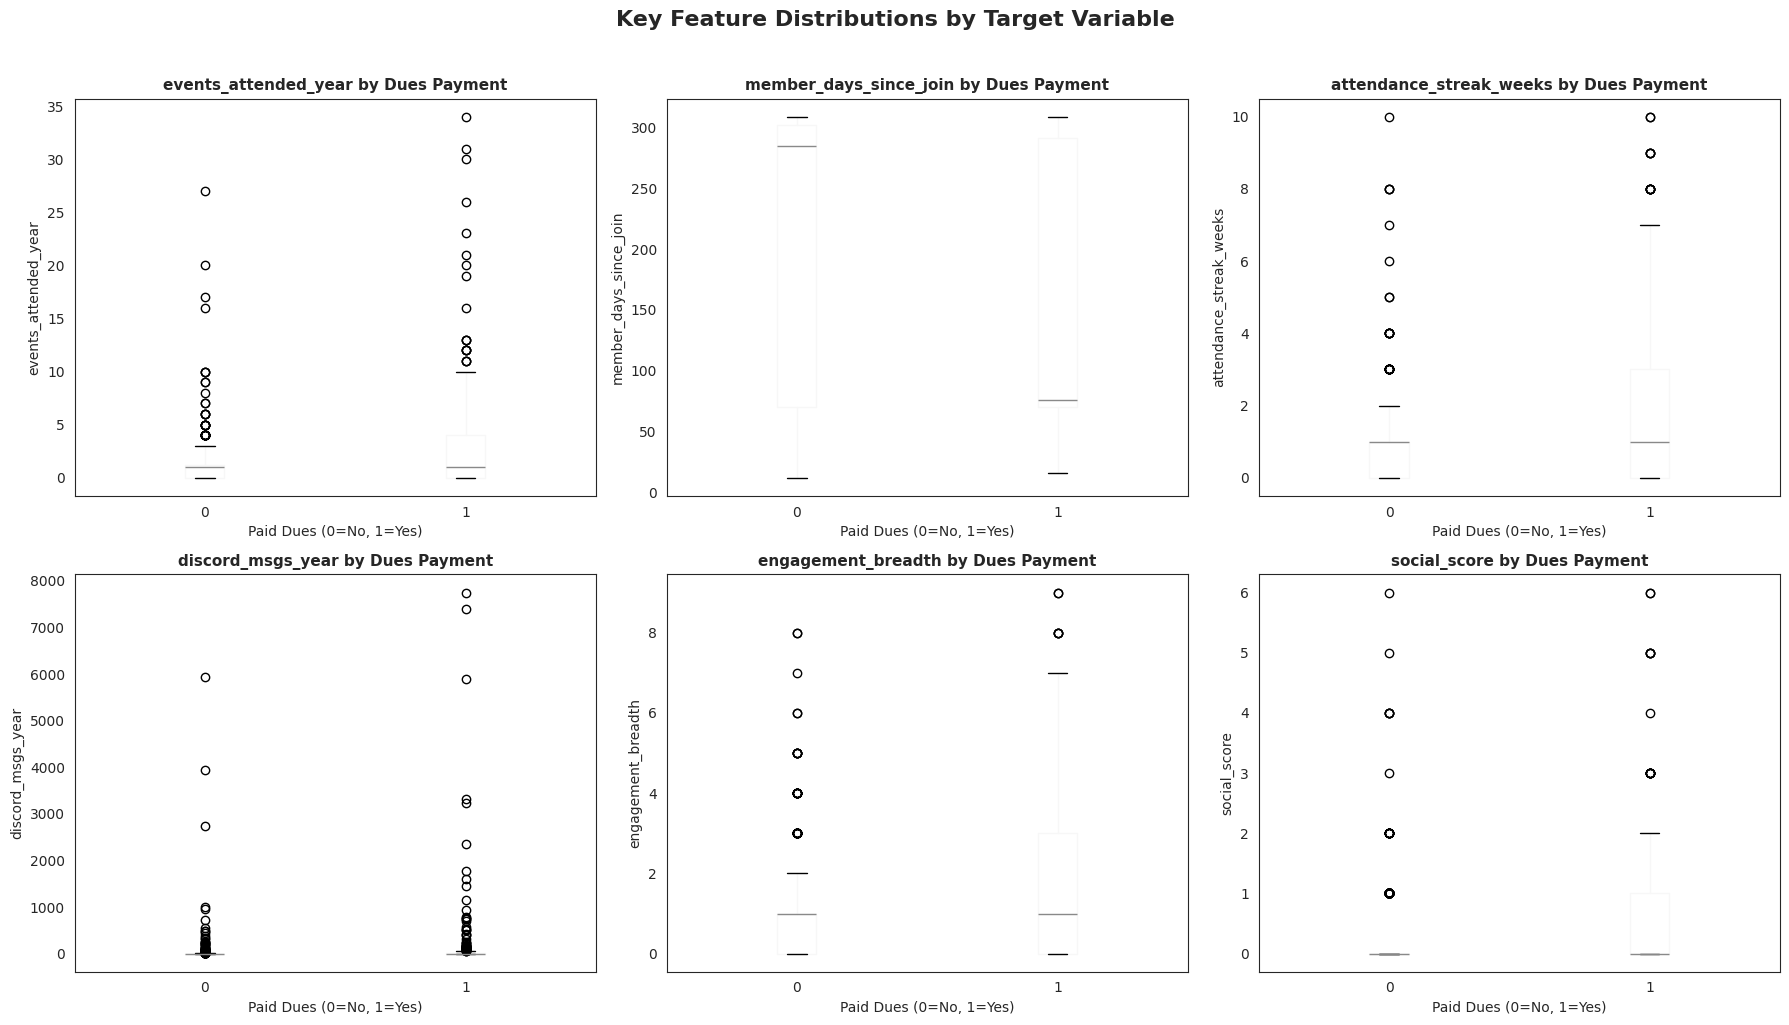

In [40]:
# Box plots for key features by target variable
key_features_subset = key_features[:6]  # Select top 6 for visualization

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(key_features_subset):
    df.boxplot(column=feature, by=target_col, ax=axes[idx], grid=False)
    axes[idx].set_title(f'{feature} by Dues Payment', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Paid Dues (0=No, 1=Yes)')
    axes[idx].set_ylabel(feature)

plt.tight_layout()
plt.suptitle('Key Feature Distributions by Target Variable', fontsize=16, fontweight='bold', y=1.02)
plt.show()


## 5. Categorical Features Analysis


In [35]:
# Get categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Analyze categorical features
if len(categorical_cols) > 0:
    print("CATEGORICAL FEATURES ANALYSIS")
    print("="*80)
    
    for col in categorical_cols:
        print(f"\n{col}:")
        print(df[col].value_counts())
        print(f"Unique values: {df[col].nunique()}")
else:
    print("No categorical features found.")


CATEGORICAL FEATURES ANALYSIS

class:
class
Senior         298
Junior         240
Sophomore      126
Freshman        76
High School     61
Graduate        24
Alumni          13
Name: count, dtype: int64
Unique values: 7

school_grouped:
school_grouped
UCF      805
Other     33
Name: count, dtype: int64
Unique values: 2

major_grouped:
major_grouped
Computer Science          760
Other                      33
Information Technology     26
Computer Engineering       19
Name: count, dtype: int64
Unique values: 4


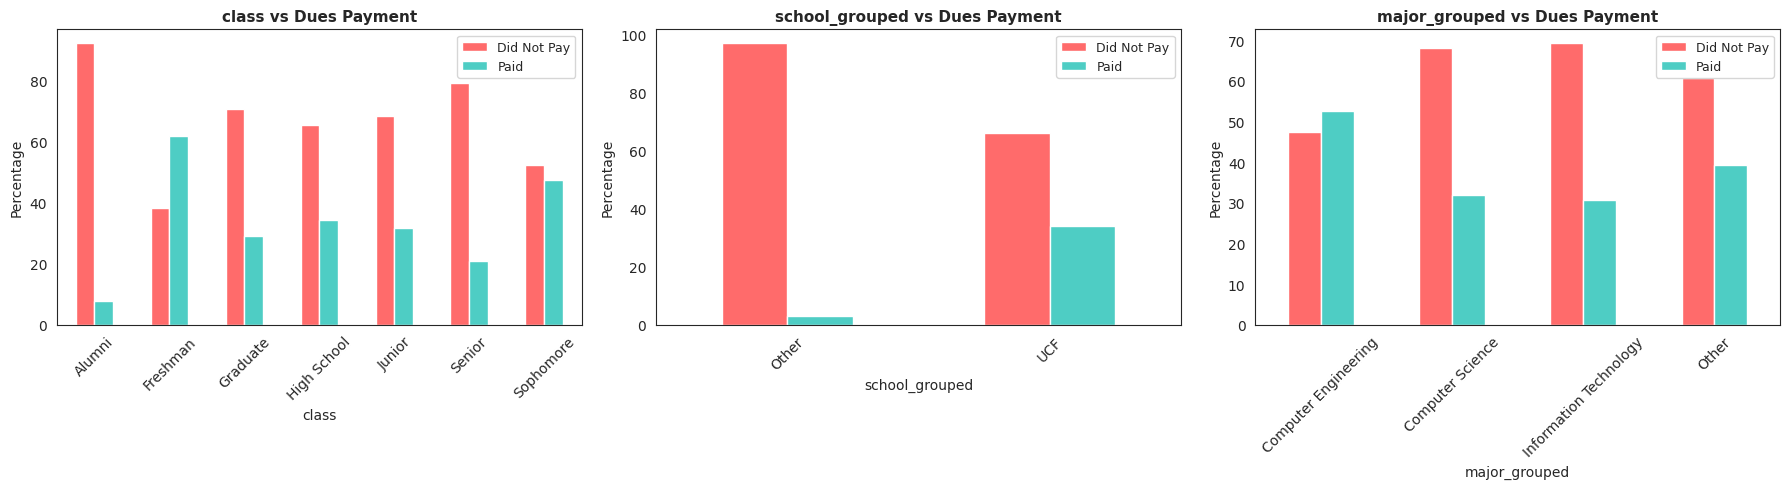

In [36]:
# Visualize categorical features vs target
categorical_to_plot = [col for col in categorical_cols if df[col].nunique() <= 10]

if len(categorical_to_plot) > 0:
    n_cols = min(3, len(categorical_to_plot))
    n_rows = (len(categorical_to_plot) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for idx, col in enumerate(categorical_to_plot):
        if idx < len(axes):
            cross_tab = pd.crosstab(df[col], df[target_col], normalize='index') * 100
            cross_tab.plot(kind='bar', ax=axes[idx], color=['#FF6B6B', '#4ECDC4'], stacked=False)
            axes[idx].set_title(f'{col} vs Dues Payment', fontsize=11, fontweight='bold')
            axes[idx].set_xlabel(col)
            axes[idx].set_ylabel('Percentage')
            axes[idx].legend(['Did Not Pay', 'Paid'], fontsize=9)
            axes[idx].tick_params(axis='x', rotation=45)
            axes[idx].grid(False)
    
    # Hide extra subplots
    for idx in range(len(categorical_to_plot), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No categorical features with <= 10 unique values to visualize.")


## 6. Feature Relationships & Scatter Plots


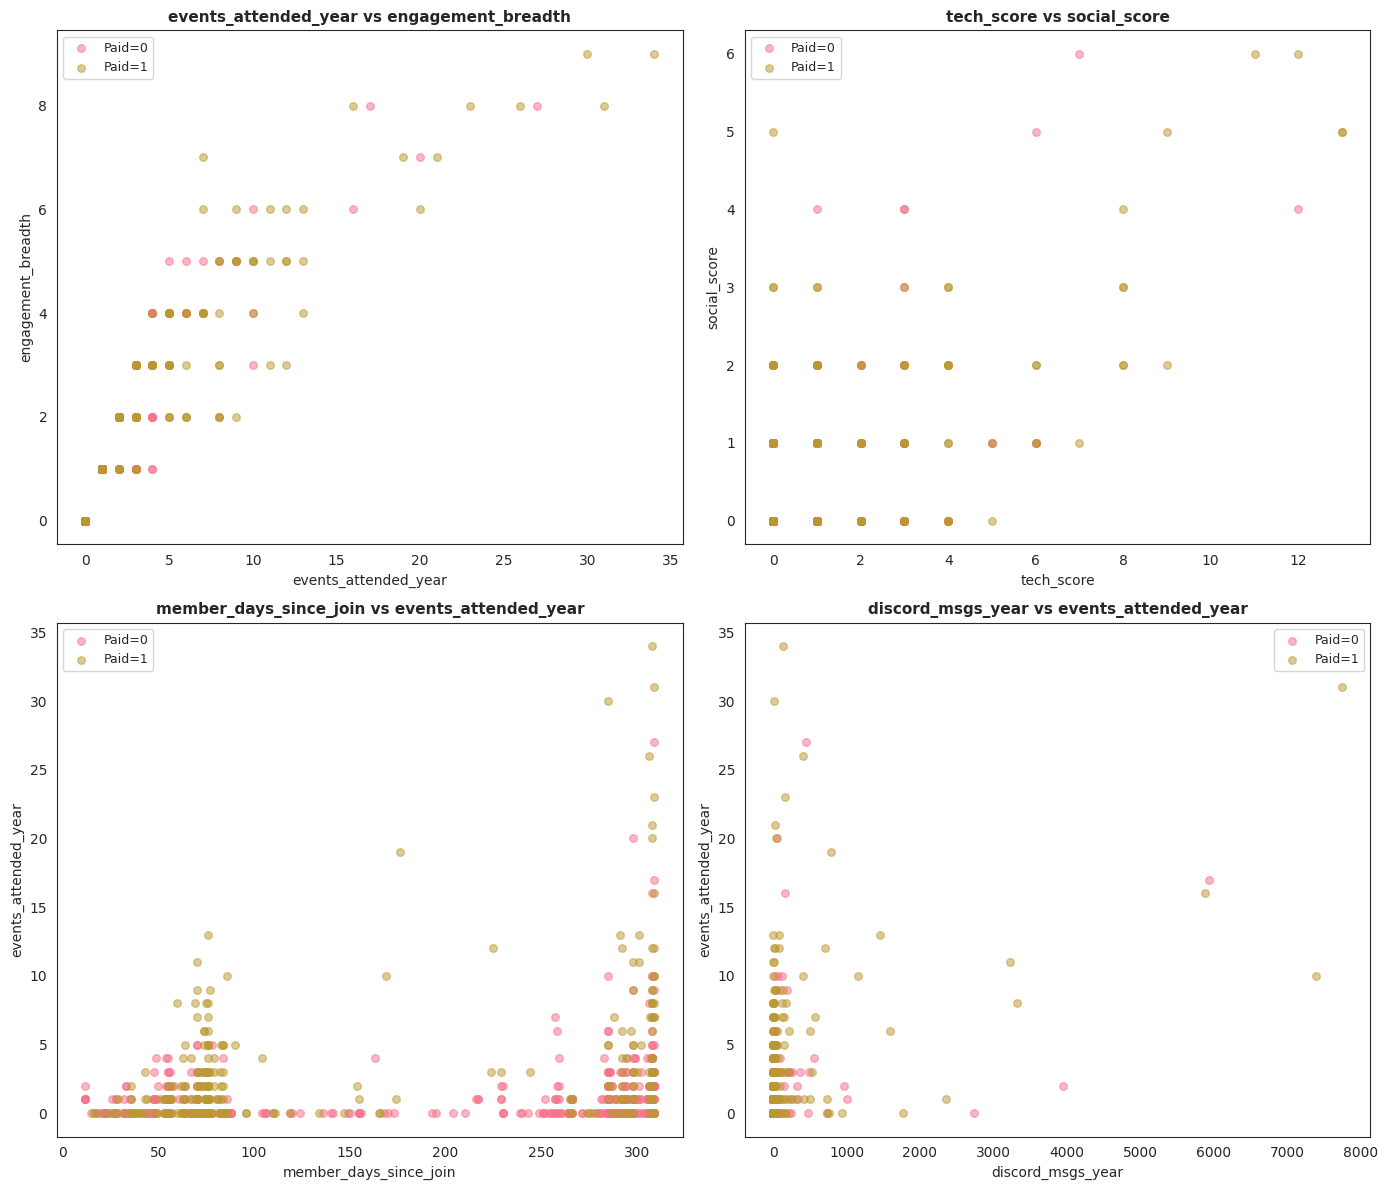

In [37]:
# Scatter plots for key feature relationships
key_pairs = [
    ('events_attended_year', 'engagement_breadth'),
    ('tech_score', 'social_score'),
    ('member_days_since_join', 'events_attended_year'),
    ('discord_msgs_year', 'events_attended_year')
]

# Filter to existing pairs
key_pairs = [(f1, f2) for f1, f2 in key_pairs if f1 in numerical_cols and f2 in numerical_cols]

if len(key_pairs) > 0:
    n_pairs = len(key_pairs)
    n_cols = 2
    n_rows = (n_pairs + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6*n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for idx, (f1, f2) in enumerate(key_pairs):
        if idx < len(axes):
            # Color by target
            for target_val in [0, 1]:
                subset = df[df[target_col] == target_val]
                axes[idx].scatter(subset[f1], subset[f2], alpha=0.5, 
                               label=f'Paid={target_val}', s=30)
            axes[idx].set_xlabel(f1, fontsize=10)
            axes[idx].set_ylabel(f2, fontsize=10)
            axes[idx].set_title(f'{f1} vs {f2}', fontsize=11, fontweight='bold')
            axes[idx].legend(fontsize=9)
            axes[idx].grid(False)
    
    # Hide extra subplots
    for idx in range(len(key_pairs), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()


## 7. ANOVA (Analysis of Variance) Tests

In [43]:
from scipy.stats import f_oneway

# Perform ANOVA tests for key numerical features
# ANOVA tests: H0 (null hypothesis): means are equal across groups
#              H1 (alternative): at least one mean is different

print("="*80)
print("ANOVA TEST RESULTS")
print("="*80)

anova_results = []

# Select key numerical features to test
features_to_test = key_features[:15]  # Test top 15 key features

for feature in features_to_test:
    if feature in numerical_cols:
        # Split data by target variable
        group_0 = df[df[target_col] == 0][feature].dropna()
        group_1 = df[df[target_col] == 1][feature].dropna()
        
        # Perform one-way ANOVA
        f_statistic, p_value = f_oneway(group_0, group_1)
        
        # Determine significance
        alpha = 0.05
        is_significant = "Yes" if p_value < alpha else "No"
        
        # Calculate means for each group
        mean_0 = group_0.mean()
        mean_1 = group_1.mean()
        
        anova_results.append({
            'Feature': feature,
            'F-Statistic': f_statistic,
            'P-Value': p_value,
            'Significant (p<0.05)': is_significant,
            'Mean (Did Not Pay)': mean_0,
            'Mean (Paid)': mean_1,
            'Difference': mean_1 - mean_0
        })

# Create results DataFrame
anova_df = pd.DataFrame(anova_results)
anova_df = anova_df.sort_values('P-Value')

print("\nANOVA Test Results (sorted by P-Value):")
print(anova_df.round(4).to_string(index=False))

print("\n" + "-"*80)
print(f"\nFeatures with significant differences (p < 0.05): {anova_df[anova_df['P-Value'] < 0.05].shape[0]}")
print(f"Features without significant differences (p >= 0.05): {anova_df[anova_df['P-Value'] >= 0.05].shape[0]}")
print("="*80)


ANOVA TEST RESULTS

ANOVA Test Results (sorted by P-Value):
                Feature  F-Statistic  P-Value Significant (p<0.05)  Mean (Did Not Pay)  Mean (Paid)  Difference
attendance_streak_weeks     108.0724   0.0000                  Yes              0.8564       2.0657      1.2093
     engagement_breadth      71.2029   0.0000                  Yes              0.8741       1.7956      0.9215
   events_attended_year      63.0320   0.0000                  Yes              1.1968       3.2153      2.0185
           social_score      61.8448   0.0000                  Yes              0.2589       0.7336      0.4747
 member_days_since_join      51.5970   0.0000                  Yes            205.5833     146.7664    -58.8169
      discord_msgs_year      12.1465   0.0005                  Yes             41.6525     180.4051    138.7526

--------------------------------------------------------------------------------

Features with significant differences (p < 0.05): 6
Features without sign

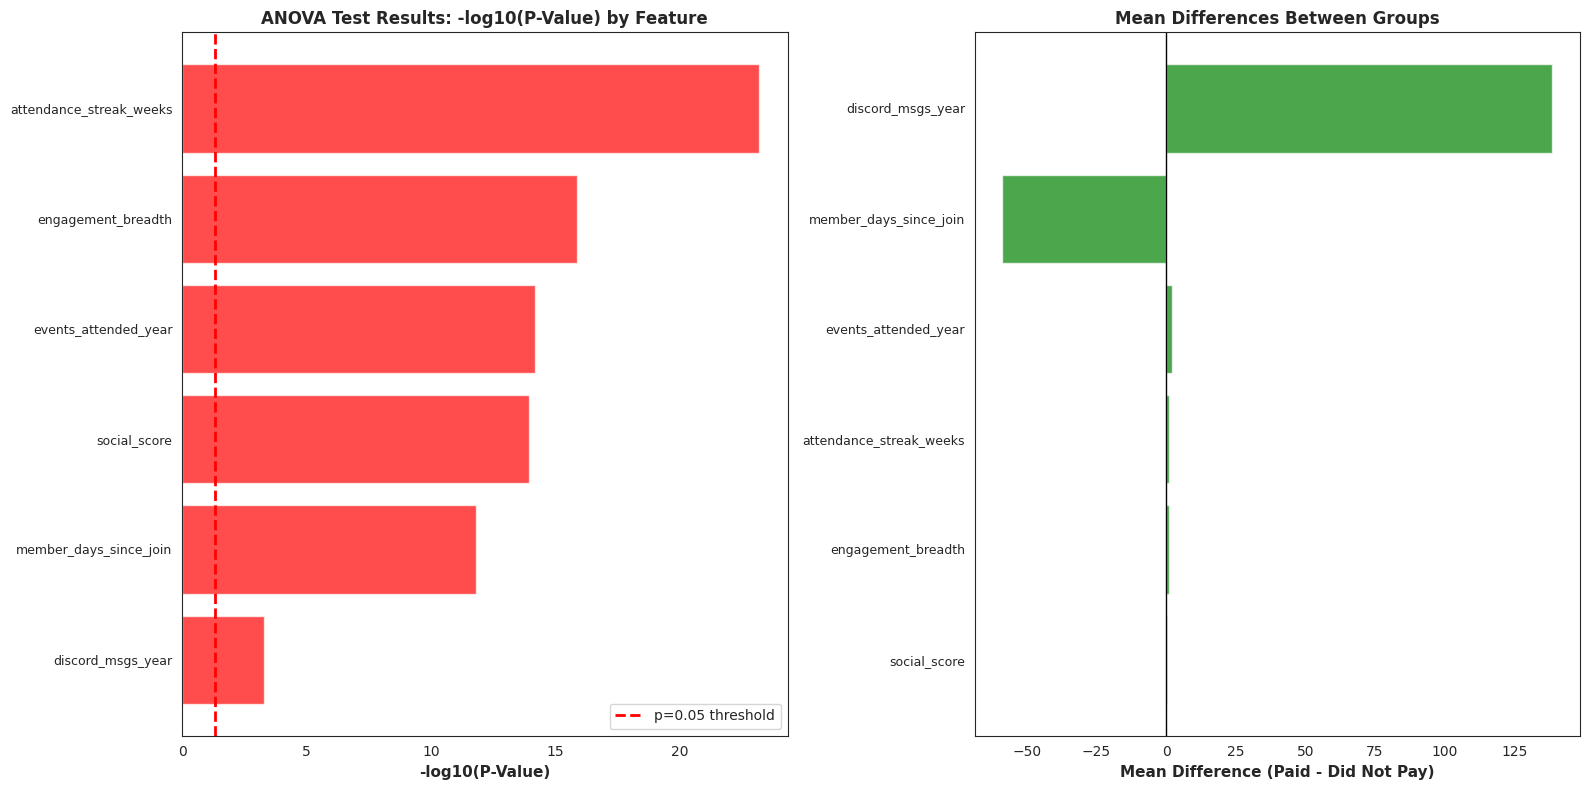


Interpretation:
- Red/Green bars indicate statistically significant differences (p < 0.05)
- Gray bars indicate no significant difference (p >= 0.05)
- The higher the bar in the left plot, the more significant the difference
- Positive differences in right plot mean 'Paid' group has higher values


In [44]:
# Visualize ANOVA results
# Plot P-values for all features
significant_features = anova_df[anova_df['P-Value'] < 0.05]
non_significant_features = anova_df[anova_df['P-Value'] >= 0.05]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: P-values (bar chart)
y_pos = np.arange(len(anova_df))
colors = ['red' if p < 0.05 else 'gray' for p in anova_df['P-Value']]

axes[0].barh(y_pos, -np.log10(anova_df['P-Value']), color=colors, alpha=0.7)
axes[0].axvline(x=-np.log10(0.05), color='red', linestyle='--', linewidth=2, label='p=0.05 threshold')
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(anova_df['Feature'], fontsize=9)
axes[0].set_xlabel('-log10(P-Value)', fontsize=11, fontweight='bold')
axes[0].set_title('ANOVA Test Results: -log10(P-Value) by Feature', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(False)
axes[0].invert_yaxis()  # Top to bottom

# Plot 2: Mean differences between groups
anova_df_sorted = anova_df.sort_values('Difference', key=abs, ascending=False)
y_pos2 = np.arange(len(anova_df_sorted))
colors2 = ['green' if p < 0.05 else 'gray' for p in anova_df_sorted['P-Value']]

bars = axes[1].barh(y_pos2, anova_df_sorted['Difference'], color=colors2, alpha=0.7)
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=1)
axes[1].set_yticks(y_pos2)
axes[1].set_yticklabels(anova_df_sorted['Feature'], fontsize=9)
axes[1].set_xlabel('Mean Difference (Paid - Did Not Pay)', fontsize=11, fontweight='bold')
axes[1].set_title('Mean Differences Between Groups', fontsize=12, fontweight='bold')
axes[1].grid(False)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Red/Green bars indicate statistically significant differences (p < 0.05)")
print("- Gray bars indicate no significant difference (p >= 0.05)")
print("- The higher the bar in the left plot, the more significant the difference")
print("- Positive differences in right plot mean 'Paid' group has higher values")


In [ ]:
# Detailed view of top significant features
print("\n" + "="*80)
print("TOP 5 MOST SIGNIFICANT FEATURES (Lowest P-Values)")
print("="*80)
top_significant = anova_df.head(5)

for idx, row in top_significant.iterrows():
    print(f"\n{row['Feature']}:")
    print(f"  F-Statistic: {row['F-Statistic']:.4f}")
    print(f"  P-Value: {row['P-Value']:.6f}")
    print(f"  Mean (Did Not Pay): {row['Mean (Did Not Pay)']:.4f}")
    print(f"  Mean (Paid): {row['Mean (Paid)']:.4f}")
    print(f"  Difference: {row['Difference']:.4f} ({'Higher' if row['Difference'] > 0 else 'Lower'} for paid group)")
    print(f"  Interpretation: {'Significant difference' if row['P-Value'] < 0.05 else 'No significant difference'}")

print("\n" + "="*80)


## 8. Insights & Summary


In [41]:
# Key insights summary
print("="*80)
print("KEY INSIGHTS SUMMARY")
print("="*80)

print(f"\n1. Dataset Size: {df.shape[0]:,} observations, {df.shape[1]} features")
print(f"2. Target Distribution: {target_pct[0]:.1f}% did not pay, {target_pct[1]:.1f}% paid dues")
print(f"3. Class Imbalance: {target_counts[0] / target_counts[1]:.2f}:1 ratio")

print(f"\n4. Top Positive Correlations with Target:")
for i, (feat, corr) in enumerate(target_corr[target_corr > 0].head(5).items(), 1):
    print(f"   {i}. {feat}: {corr:.3f}")

print(f"\n5. Top Negative Correlations with Target:")
for i, (feat, corr) in enumerate(target_corr[target_corr < 0].tail(5).items(), 1):
    print(f"   {i}. {feat}: {corr:.3f}")

print(f"\n6. Numerical Features: {len(numerical_cols)}")
print(f"7. Categorical Features: {len(categorical_cols)}")

print("\n" + "="*80)


KEY INSIGHTS SUMMARY

1. Dataset Size: 838 observations, 36 features
2. Target Distribution: 67.3% did not pay, 32.7% paid dues
3. Class Imbalance: 2.06:1 ratio

4. Top Positive Correlations with Target:
   1. attendance_streak_weeks: 0.338
   2. has_gone_to_hackathon: 0.333
   3. distinct_event_days_year: 0.322
   4. engagement_breadth: 0.280
   5. has_role_ops: 0.277

5. Top Negative Correlations with Target:
   1. is_sponsor_hunter: -0.038
   2. n_class_support_year: -0.069
   3. discord_days_since_join: -0.071
   4. class_support_ratio: -0.167
   5. member_days_since_join: -0.241

6. Numerical Features: 32
7. Categorical Features: 3

